In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import List
np.set_printoptions(threshold=np.inf)  

from fragment import *
from side import *
from sides_comparison import *
from utils import *
from puzzle import *
import global_values
from displaying import *
from groups import *


In [ ]:
image_path = "disney_puzzle/snow_white.jpg" 
# image_path = "angry.jpg"
output_folder = "fragments"
global_values.COL_NR = 15
global_values.ROW_NR = 15
fragments, tile_h, tile_w = divide_image(image_path, output_folder, global_values.COL_NR, global_values.ROW_NR)
global_values.TILE_H = global_values.TILE_W = max(tile_h, tile_w)

sides_comparisons = create_sides_comparisons(fragments)
sorted_sides_comparisons = sort_sides_comparisons(sides_comparisons)

n = len(fragments)
s = 4  
global_values.SYMMETRIC_COMPARISONS = [[[[None for _ in range(s)] for _ in range(s)] for _ in range(n)] for _ in range(n)]

for c in sides_comparisons:
    global_values.SYMMETRIC_COMPARISONS[c.side1.fragment_idx][c.side2.fragment_idx][c.side1.side_idx][c.side2.side_idx] = c
    symmetric_comp = SidesComparison(fragments, c.side2, c.side1)
    global_values.SYMMETRIC_COMPARISONS[c.side2.fragment_idx][c.side1.fragment_idx][c.side2.side_idx][c.side1.side_idx] = symmetric_comp



 48%|████▊     | 107/224 [00:08<00:06, 17.35it/s]

In [ ]:
groups = []
fragment_idx_to_group_idx = [None for _ in fragments]

for fr_idx in range(len(fragments)):
    new_group = Group(fr_idx)
    groups.append(new_group)
    fragment_idx_to_group_idx[fr_idx] = fr_idx
# show_all_groups(groups, fragments)
print(fragment_idx_to_group_idx)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

0.002032592406179858
Sides Comp: Score=0.002032592406179858 Fragment_idx1=153, Side_idx1=2; fragment_idx2=168, side_idx2=0
0.004622858390964507
Sides Comp: Score=0.004622858390964508 Fragment_idx1=110, Side_idx1=1; fragment_idx2=111, side_idx2=3
0.005227292835090675
Sides Comp: Score=0.005227292835090677 Fragment_idx1=181, Side_idx1=1; fragment_idx2=182, side_idx2=3
0.005381808280570498
Sides Comp: Score=0.005381808280570499 Fragment_idx1=1, Side_idx1=1; fragment_idx2=2, side_idx2=3
0.005553296331728801
Sides Comp: Score=0.005535021875474824 Fragment_idx1=25, Side_idx1=1; fragment_idx2=26, side_idx2=3
0.00556371129665916
Sides Comp: Score=0.0055637112966591615 Fragment_idx1=109, Side_idx1=1; fragment_idx2=110, side_idx2=3
0.005807753835447967
Sides Comp: Score=0.0058077538354479675 Fragment_idx1=10, Side_idx1=1; fragment_idx2=11, side_idx2=3
0.005868062484974498
Sides Comp: Score=0.005868062484974496 Fragment_idx1=111, Side_idx1=1; fragment_idx2=112, side_idx2=3
0.006021645093759726
Si

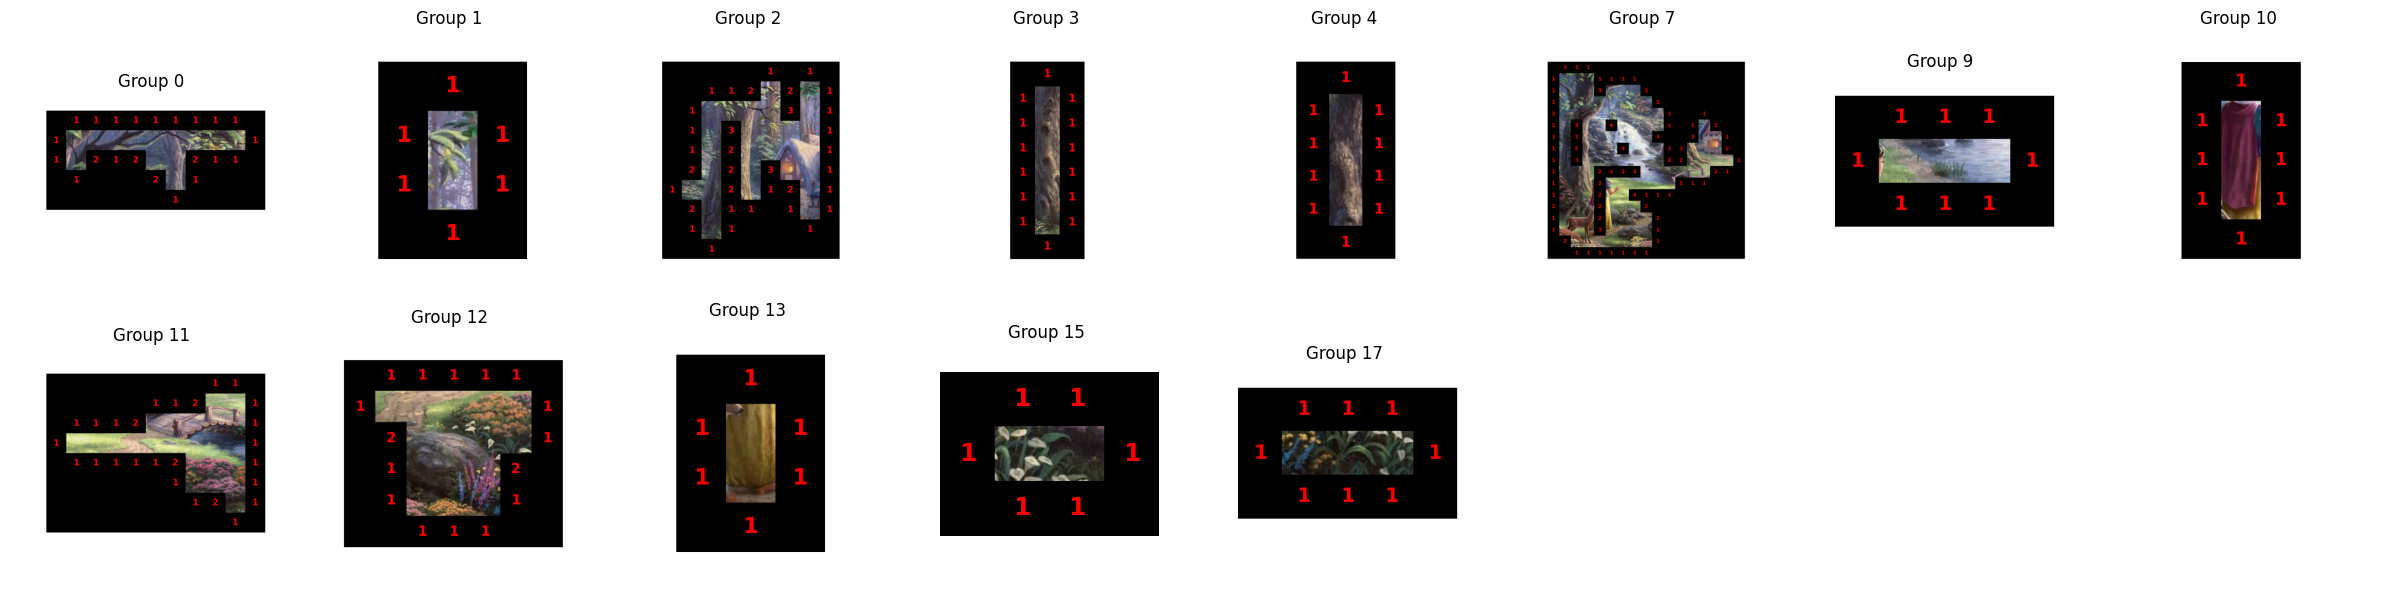

{3: [1, 1], 18: [2, 1], 4: [1, 2], 5: [1, 3], 6: [1, 4], 7: [1, 5], 8: [1, 6], 23: [2, 6], 38: [3, 6], 9: [1, 7], 10: [1, 8], 11: [1, 9], 22: [2, 5]}
{13: [1, 1], 28: [2, 1]}
{24: [2, 2], 12: [1, 5], 41: [3, 4], 25: [2, 3], 26: [2, 4], 27: [2, 5], 42: [3, 5], 39: [3, 2], 43: [3, 6], 56: [4, 4], 71: [5, 4], 86: [6, 4], 57: [4, 5], 58: [4, 6], 73: [5, 6], 14: [1, 7], 29: [2, 7], 44: [3, 7], 59: [4, 7], 74: [5, 7], 89: [6, 7], 104: [7, 7], 54: [4, 2], 69: [5, 2], 83: [6, 1], 84: [6, 2], 99: [7, 2], 114: [8, 2]}
{40: [1, 1], 55: [2, 1], 70: [3, 1], 85: [4, 1], 100: [5, 1], 115: [6, 1]}
{61: [1, 1], 76: [2, 1], 91: [3, 1], 106: [4, 1]}
{64: [1, 1]}
{95: [1, 1]}
{101: [7, 12], 102: [7, 13], 72: [5, 13], 87: [6, 13], 88: [6, 14], 103: [7, 14], 135: [10, 1], 19: [2, 5], 20: [2, 6], 21: [2, 7], 75: [6, 1], 90: [7, 1], 105: [8, 1], 120: [9, 1], 121: [9, 2], 15: [2, 1], 30: [3, 1], 45: [4, 1], 60: [5, 1], 0: [1, 1], 1: [1, 2], 2: [1, 3], 16: [2, 2], 17: [2, 3], 31: [3, 2], 32: [3, 3], 46: [4, 2],

In [ ]:
for comp in sorted_sides_comparisons:
    if comp.score < 0.2:
        anchor_fragment_idx = comp.side1.fragment_idx
        pasted_fragment_idx = comp.side2.fragment_idx
        anchor_group_idx = fragment_idx_to_group_idx[anchor_fragment_idx]
        pasted_group_idx = fragment_idx_to_group_idx[pasted_fragment_idx]
        if anchor_group_idx != pasted_group_idx:
            if check_groups_shapes_for_merging(comp, groups[anchor_group_idx], groups[pasted_group_idx]):
                if does_merge_fit_within_bounds(comp,groups[anchor_group_idx], groups[pasted_group_idx]):
                    if check_all_group_matchings_scores(comp, groups[anchor_group_idx], groups[pasted_group_idx]):                        
                        merge_groups(comp, fragments, fragment_idx_to_group_idx, groups[anchor_group_idx], groups[pasted_group_idx])
                        update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_group_idx)
                        print(comp)
show_all_groups(groups, fragments, fragment_idx_to_group_idx)

for g in groups:
    print(g.fragment_positions)

In [ ]:




# groups, fragments, fragment_idx_to_group_idx = solve_groups(groups, fragments, fragment_idx_to_group_idx)
# show_all_groups(groups, fragments, fragment_idx_to_group_idx)
while len(groups) > 1:

    edges_of_groups_df = edges_of_groups(groups)
    merge_candidates = []
    if edges_of_groups_df.empty:
        print("No empty spots with neighbours left.")
        break
    max_neighbours = edges_of_groups_df['nr_of_neighbours'][0]

    for _, row in edges_of_groups_df.iterrows():
        if row['nr_of_neighbours'] == max_neighbours:
            candidate = find_best_candidate_for_empty_spot(row, groups)
            if candidate:
                merge_candidates.append(candidate)

    if not merge_candidates:
        print("No valid merge candidates found.")
        break

    merge_candidates.sort(key=lambda c: c['score'])
    # for m in merge_candidates:
    #     print(m)
    while merge_candidates:
        best = merge_candidates.pop(0)
        comp = best['comp']
        anchor_idx = best['anchor_group_idx']
        pasted_idx = best['pasted_group_idx']

        if check_groups_shapes_for_merging(comp, groups[anchor_idx], groups[pasted_idx]) and \
           does_merge_fit_within_bounds(comp, groups[anchor_idx], groups[pasted_idx]):

            merge_groups(comp, fragments, fragment_idx_to_group_idx, groups[anchor_idx], groups[pasted_idx])
            update_after_merge(groups, fragments, fragment_idx_to_group_idx, pasted_idx)
            print(f"Merged group {anchor_idx} and {pasted_idx} using: {comp}")
            # show_all_groups(groups, fragments, fragment_idx_to_group_idx)

            break

    else:
        print("No suitable merge candidate found after filtering.")
        break

show_all_groups(groups, fragments, fragment_idx_to_group_idx)


Merged group 7 and 5 using: Sides Comp: Score=0.18976399836071808 Fragment_idx1=49, Side_idx1=2; fragment_idx2=64, side_idx2=0


KeyError: 80